In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input
from sklearn.model_selection import train_test_split
import pprint as pp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")
df = df[(df["item"]==1) & (df['store']==1)] # Store 1 and item 1 only
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

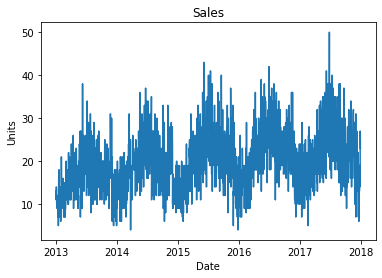

In [ ]:
plt.plot(df['date'],df['sales'])
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Units')
plt.show()

In [ ]:
raw_seq = df['sales']

In [ ]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
def cnn_model(n_steps, n_features):
    inputs = Input(shape=(n_steps, n_features))
    X = Conv1D(480, 2, activation='relu')(inputs)
    X = AveragePooling1D()(X)
    X = Flatten()(X)
    X = Dense(336, activation='relu')(X)
    outputs = Dense(1)(X)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cnn_model")
    return model

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
def run_model(seq, n_steps):
    X, y = split_sequence(raw_seq, n_steps=5)
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = cnn_model(n_steps, n_features)
    model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])
    # fit model
    hist =  model.fit(X_train, y_train, batch_size=120, epochs=2000, verbose=2, validation_data=(X_test, y_test), callbacks=[callback])
    score = model.evaluate(X_test, y_test, return_dict=True)
    return (hist, score)

In [ ]:
hist, score = run_model(raw_seq, 5)

Epoch 1/2000
13/13 - 1s - loss: 117.0582 - root_mean_squared_error: 10.8193 - mean_absolute_percentage_error: 46.8357 - val_loss: 36.9503 - val_root_mean_squared_error: 6.0787 - val_mean_absolute_percentage_error: 27.7110 - 1s/epoch - 80ms/step
Epoch 2/2000
13/13 - 0s - loss: 41.6220 - root_mean_squared_error: 6.4515 - mean_absolute_percentage_error: 26.6050 - val_loss: 36.2981 - val_root_mean_squared_error: 6.0248 - val_mean_absolute_percentage_error: 26.0544 - 134ms/epoch - 10ms/step
Epoch 3/2000
13/13 - 0s - loss: 35.6307 - root_mean_squared_error: 5.9691 - mean_absolute_percentage_error: 27.8760 - val_loss: 35.8350 - val_root_mean_squared_error: 5.9862 - val_mean_absolute_percentage_error: 26.1435 - 137ms/epoch - 11ms/step
Epoch 4/2000
13/13 - 0s - loss: 34.6654 - root_mean_squared_error: 5.8877 - mean_absolute_percentage_error: 27.0314 - val_loss: 35.5833 - val_root_mean_squared_error: 5.9652 - val_mean_absolute_percentage_error: 25.9343 - 130ms/epoch - 10ms/step
Epoch 5/2000
13/1

In [ ]:
cnn_result = pd.DataFrame(hist.history)
cnn_result.to_excel('cnn_result.xlsx')

In [ ]:
score

{'loss': 33.70719909667969,
 'mean_absolute_percentage_error': 26.957237243652344,
 'root_mean_squared_error': 5.805789947509766}